In [4]:
from scipy.spatial import KDTree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV



In [6]:
# Load datasets
dataset1 = pd.read_csv("data/workout_fitness_tracker_data.csv")
dataset2 = pd.read_csv("data/health_fitness_dataset.csv")

dataset1["BMI"] = dataset1["Weight (kg)"] / ((dataset1["Height (cm)"] / 100) ** 2)

# Standardize Gender Labels
gender_map = {"Male": "M", "Female": "F", "Other": "Other"}  # Keep "Other"
dataset1["Gender"] = dataset1["Gender"].map(gender_map)

# Rename Dataset 2 columns for consistency
dataset2 = dataset2.rename(columns={
    "age": "Age",
    "height_cm": "Height (cm)",
    "weight_kg": "Weight (kg)",
    "resting_heart_rate": "Resting Heart Rate (bpm)",
    "bmi": "BMI",
    "gender": "Gender"
})

# Define matching features & their weights
features = ["Age", "Height (cm)", "Weight (kg)", "Resting Heart Rate (bpm)", "BMI"]
feature_weights = np.array([1, 1, 1, 3, 3])  # More weight for Resting HR & BMI

# Separate "Other" from gender-based matching
gender_groups = ["M", "F"]
merged_dataframes = []

for gender in gender_groups:  # Match "M" to "M" and "F" to "F"
    ds1_filtered = dataset1[dataset1["Gender"] == gender].copy()
    ds2_filtered = dataset2[dataset2["Gender"] == gender].copy()

    # NEW: Drop rows with missing values in required features
    ds1_filtered = ds1_filtered.dropna(subset=features)
    ds2_filtered = ds2_filtered.dropna(subset=features)

    if ds2_filtered.empty or ds1_filtered.empty:
        print(f"⚠️ No matching users found in Dataset 2 for gender: {gender}")
        continue

    # Extract & normalize features
    scaler = MinMaxScaler()
    ds1_scaled = scaler.fit_transform(ds1_filtered[features]) * feature_weights
    ds2_scaled = scaler.transform(ds2_filtered[features]) * feature_weights

    # Check and clean NaN or inf values in scaled datasets
    if np.any(np.isnan(ds1_scaled)) or np.any(np.isinf(ds1_scaled)):
        print("Warning: NaN or Inf detected in ds1_scaled, cleaning...")
        ds1_scaled = np.nan_to_num(ds1_scaled, nan=0.0, posinf=0.0, neginf=0.0)
        
    if np.any(np.isnan(ds2_scaled)) or np.any(np.isinf(ds2_scaled)):
        print("Warning: NaN or Inf detected in ds2_scaled, cleaning...")
        ds2_scaled = np.nan_to_num(ds2_scaled, nan=0.0, posinf=0.0, neginf=0.0)

    # KD-Tree for nearest-neighbor search
    kd_tree = KDTree(ds2_scaled)
    distances, best_matches = kd_tree.query(ds1_scaled, k=1)

    # Merge results
    best_match_df = ds2_filtered.iloc[best_matches].reset_index(drop=True)
    merged_df = ds1_filtered.reset_index(drop=True).copy()

    # Keep Dataset 1 values and add only unique columns from Dataset 2
    ds2_unique_cols = [col for col in dataset2.columns if col not in dataset1.columns]
    merged_df[ds2_unique_cols] = best_match_df[ds2_unique_cols].values
    merged_df["Match Distance"] = distances  # Lower = better match

    merged_dataframes.append(merged_df)

# Handle "Other" separately (match based on closest features, ignoring gender)
ds1_other = dataset1[dataset1["Gender"] == "Other"].copy()
if not ds1_other.empty:
    scaler = MinMaxScaler()
    ds1_other_scaled = scaler.fit_transform(ds1_other[features]) * feature_weights
    ds2_all_scaled = scaler.transform(dataset2[features]) * feature_weights  # Match to all dataset2 users

    # Check and clean NaN or inf values in scaled datasets
    if np.any(np.isnan(ds1_other_scaled)) or np.any(np.isinf(ds1_other_scaled)):
        print("Warning: NaN or Inf detected in ds1_other_scaled, cleaning...")
        ds1_other_scaled = np.nan_to_num(ds1_other_scaled, nan=0.0, posinf=0.0, neginf=0.0)
        
    if np.any(np.isnan(ds2_all_scaled)) or np.any(np.isinf(ds2_all_scaled)):
        print("Warning: NaN or Inf detected in ds2_all_scaled, cleaning...")
        ds2_all_scaled = np.nan_to_num(ds2_all_scaled, nan=0.0, posinf=0.0, neginf=0.0)

    kd_tree = KDTree(ds2_all_scaled)
    distances, best_matches = kd_tree.query(ds1_other_scaled, k=1)

    best_match_df = dataset2.iloc[best_matches].reset_index(drop=True)
    merged_other = ds1_other.reset_index(drop=True).copy()

    # Add unique columns from Dataset 2
    merged_other[ds2_unique_cols] = best_match_df[ds2_unique_cols].values
    merged_other["Match Distance"] = distances  # Lower = better match

    merged_dataframes.append(merged_other)

# Combine results
final_merged_dataset = pd.concat(merged_dataframes, ignore_index=True)

# Optionally, save final dataset
final_merged_dataset.to_csv("merged_dataset.csv", index=False)


In [7]:
print(final_merged_dataset.columns)

Index(['User ID', 'Age', 'Gender', 'Height (cm)', 'Weight (kg)',
       'Workout Type', 'Workout Duration (mins)', 'Calories Burned',
       'Heart Rate (bpm)', 'Steps Taken', 'Distance (km)', 'Workout Intensity',
       'Sleep Hours', 'Water Intake (liters)', 'Daily Calories Intake',
       'Resting Heart Rate (bpm)', 'VO2 Max', 'Body Fat (%)',
       'Mood Before Workout', 'Mood After Workout', 'BMI', 'participant_id',
       'date', 'activity_type', 'duration_minutes', 'intensity',
       'calories_burned', 'avg_heart_rate', 'hours_sleep', 'stress_level',
       'daily_steps', 'hydration_level', 'blood_pressure_systolic',
       'blood_pressure_diastolic', 'health_condition', 'smoking_status',
       'fitness_level', 'Match Distance'],
      dtype='object')


In [8]:

final_merged_dataset = final_merged_dataset.drop(columns=['User ID', 'duration_minutes', 'calories_burned', 'avg_heart_rate', 
                      'daily_steps', 'Match Distance', 'hours_sleep', 
                      'hydration_level', 'intensity', 'participant_id', 'date', 'activity_type', 'fitness_level'])

# Display the updated DataFrame
print(final_merged_dataset.columns)

Index(['Age', 'Gender', 'Height (cm)', 'Weight (kg)', 'Workout Type',
       'Workout Duration (mins)', 'Calories Burned', 'Heart Rate (bpm)',
       'Steps Taken', 'Distance (km)', 'Workout Intensity', 'Sleep Hours',
       'Water Intake (liters)', 'Daily Calories Intake',
       'Resting Heart Rate (bpm)', 'VO2 Max', 'Body Fat (%)',
       'Mood Before Workout', 'Mood After Workout', 'BMI', 'stress_level',
       'blood_pressure_systolic', 'blood_pressure_diastolic',
       'health_condition', 'smoking_status'],
      dtype='object')


In [9]:
final_merged_dataset.rename(columns={
    'stress_level': 'Stress Level',
    'blood_pressure_systolic': 'Blood Pressure Systolic',
    'blood_pressure_diastolic': 'Blood Pressure Diastolic',
    'health_condition': 'Health Condition',
    'smoking_status': 'Smoking Status'
}, inplace=True)

# Display the updated DataFrame
print(final_merged_dataset.columns)

Index(['Age', 'Gender', 'Height (cm)', 'Weight (kg)', 'Workout Type',
       'Workout Duration (mins)', 'Calories Burned', 'Heart Rate (bpm)',
       'Steps Taken', 'Distance (km)', 'Workout Intensity', 'Sleep Hours',
       'Water Intake (liters)', 'Daily Calories Intake',
       'Resting Heart Rate (bpm)', 'VO2 Max', 'Body Fat (%)',
       'Mood Before Workout', 'Mood After Workout', 'BMI', 'Stress Level',
       'Blood Pressure Systolic', 'Blood Pressure Diastolic',
       'Health Condition', 'Smoking Status'],
      dtype='object')


In [10]:
print(final_merged_dataset.dtypes)

Age                           int64
Gender                       object
Height (cm)                   int64
Weight (kg)                   int64
Workout Type                 object
Workout Duration (mins)       int64
Calories Burned               int64
Heart Rate (bpm)              int64
Steps Taken                   int64
Distance (km)               float64
Workout Intensity            object
Sleep Hours                 float64
Water Intake (liters)       float64
Daily Calories Intake         int64
Resting Heart Rate (bpm)      int64
VO2 Max                     float64
Body Fat (%)                float64
Mood Before Workout          object
Mood After Workout           object
BMI                         float64
Stress Level                 object
Blood Pressure Systolic      object
Blood Pressure Diastolic     object
Health Condition             object
Smoking Status               object
dtype: object


In [11]:
print(final_merged_dataset.isnull().sum())

Age                            0
Gender                         0
Height (cm)                    0
Weight (kg)                    0
Workout Type                   0
Workout Duration (mins)        0
Calories Burned                0
Heart Rate (bpm)               0
Steps Taken                    0
Distance (km)                  0
Workout Intensity              0
Sleep Hours                    0
Water Intake (liters)          0
Daily Calories Intake          0
Resting Heart Rate (bpm)       0
VO2 Max                        0
Body Fat (%)                   0
Mood Before Workout            0
Mood After Workout             0
BMI                            0
Stress Level                   0
Blood Pressure Systolic       15
Blood Pressure Diastolic      15
Health Condition            7789
Smoking Status                15
dtype: int64


In [12]:
# Mbush vlerat që mungojnë në kolonën 'Health Condition' me "Not Specified"
final_merged_dataset["Health Condition"] = final_merged_dataset["Health Condition"].fillna("Not Specified")

print(final_merged_dataset.isnull().sum())

Age                          0
Gender                       0
Height (cm)                  0
Weight (kg)                  0
Workout Type                 0
Workout Duration (mins)      0
Calories Burned              0
Heart Rate (bpm)             0
Steps Taken                  0
Distance (km)                0
Workout Intensity            0
Sleep Hours                  0
Water Intake (liters)        0
Daily Calories Intake        0
Resting Heart Rate (bpm)     0
VO2 Max                      0
Body Fat (%)                 0
Mood Before Workout          0
Mood After Workout           0
BMI                          0
Stress Level                 0
Blood Pressure Systolic     15
Blood Pressure Diastolic    15
Health Condition             0
Smoking Status              15
dtype: int64


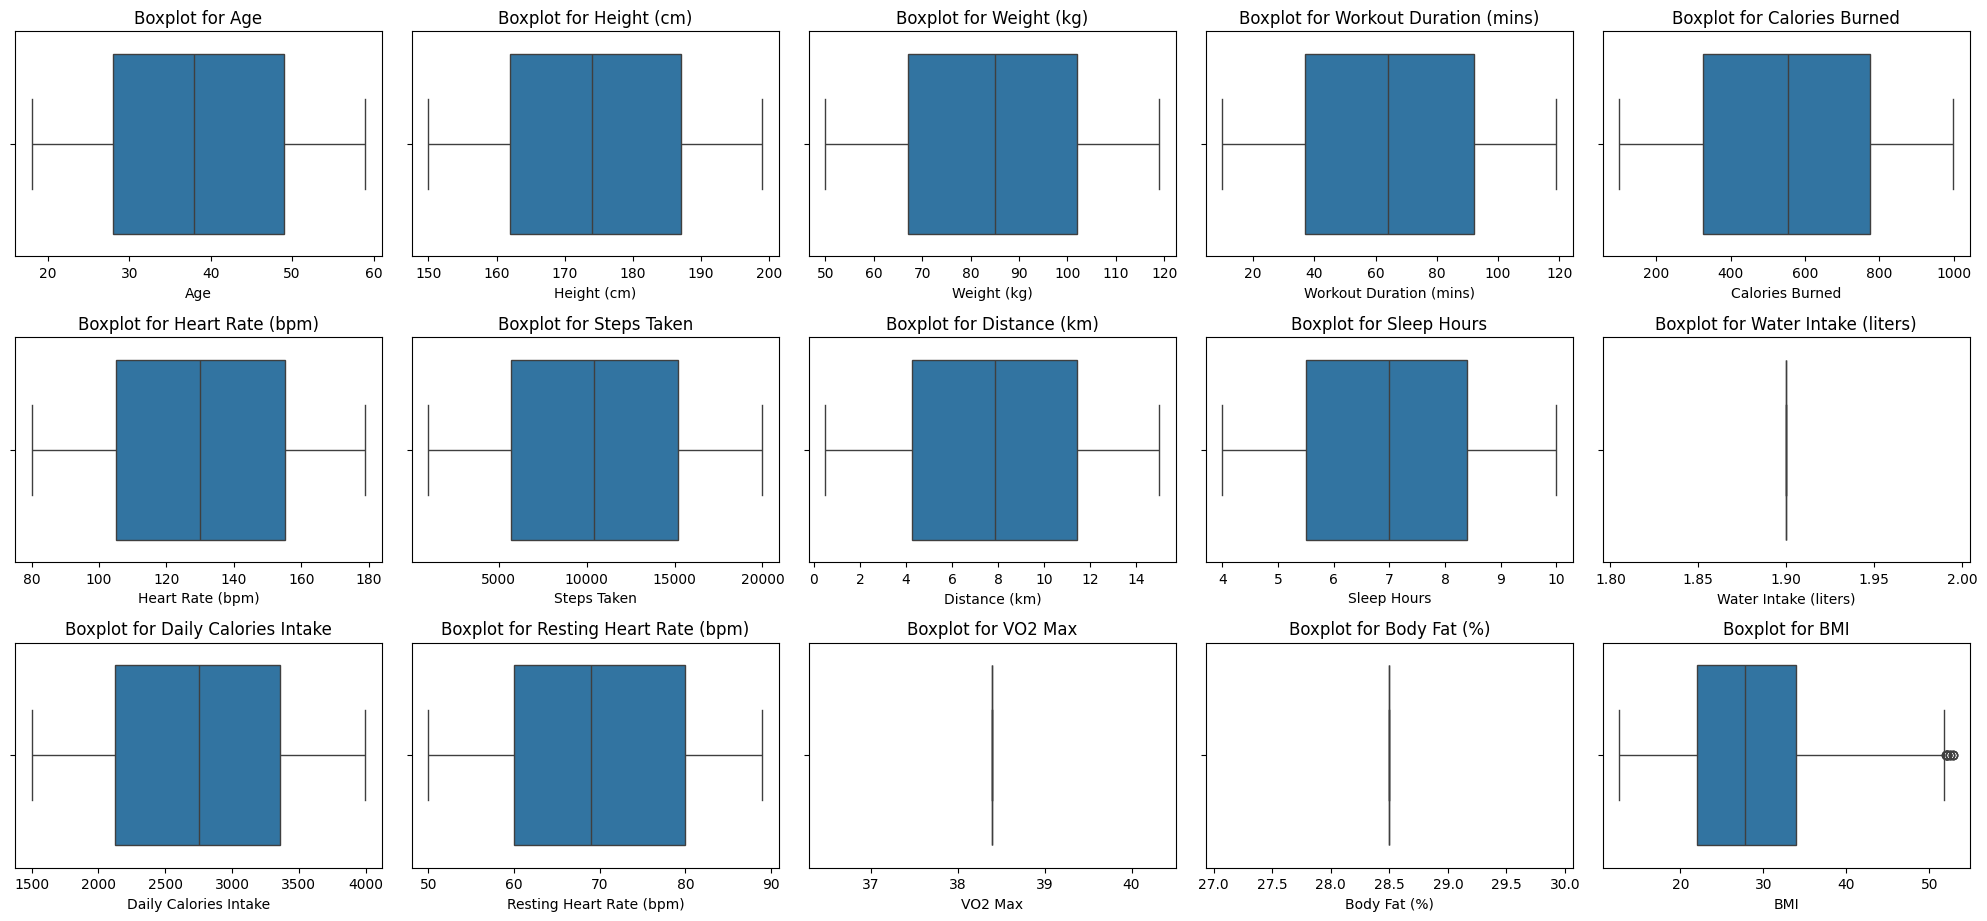

In [13]:
# Sigurohu që final_merged_dataset është i definuar dhe përmban të dhënat tuaja
# Krijo listën e kolonave numerike
numerical_cols = final_merged_dataset.select_dtypes(include=['number']).columns

# Boxplot për të parë shpërndarjen dhe outliers me grid më të madh (5x5)
plt.figure(figsize=(20, 15))  # Zgjedhje e madhësisë së figurës

for i, column in enumerate(numerical_cols, 1):
    plt.subplot(5, 5, i)  # Përdorimi i një gridi 5x5
    sns.boxplot(data=final_merged_dataset, x=column)
    plt.title(f'Boxplot for {column}')

plt.tight_layout()  # Sigurohet që të gjitha figurat të shfaqen pa mbivendosje
plt.show()

In [14]:
final_merged_dataset = final_merged_dataset.drop(columns=["Water Intake (liters)", "Body Fat (%)", "VO2 Max"])

# Funksioni për të larguar outliers duke përdorur IQR
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filtrimi i të dhënave brenda kufijve të IQR-së
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Largimi i outliers për kolona specifike
final_merged_dataset = remove_outliers_iqr(final_merged_dataset, "BMI")
final_merged_dataset = remove_outliers_iqr(final_merged_dataset, "Blood Pressure Systolic")
final_merged_dataset = remove_outliers_iqr(final_merged_dataset, "Blood Pressure Diastolic")

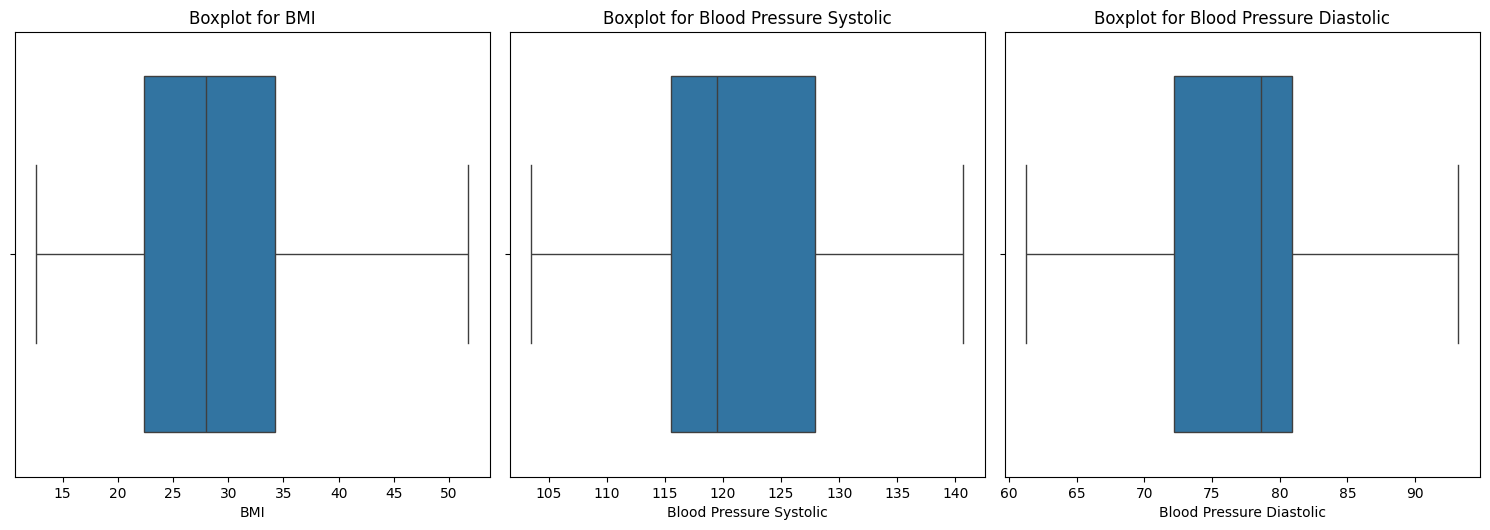

In [15]:
# Cakto kolonat që do të shfaqen
cols_to_plot = ["BMI", "Blood Pressure Systolic", "Blood Pressure Diastolic"]

# Boxplot për secilën kolone
plt.figure(figsize=(15, 10))
for i, column in enumerate(cols_to_plot, 1):
    plt.subplot(2, 3, i)  # Grid 2x3 për 3 kolona
    sns.boxplot(data=final_merged_dataset, x=column)
    plt.title(f'Boxplot for {column}')
    plt.tight_layout()

plt.show()

In [16]:
# Definimi i kolonave që do të kodohen
label_encode_cols = ["Mood Before Workout", "Mood After Workout", "Smoking Status", "Health Condition", "Gender"]
one_hot_encode_cols = ["Workout Type", "Workout Intensity"]

# Aplikimi i Label Encoding
label_encoder = LabelEncoder()
for col in label_encode_cols:
    final_merged_dataset[col] = label_encoder.fit_transform(final_merged_dataset[col])

# Aplikimi i One-Hot Encoding
final_merged_dataset = pd.get_dummies(final_merged_dataset, columns=one_hot_encode_cols, drop_first=True)

# Shfaq disa rreshta për të parë rezultatin
print(final_merged_dataset.head())

   Age  Gender  Height (cm)  Weight (kg)  Workout Duration (mins)  \
0   39       1          175           99                       79   
1   56       1          154           89                       39   
2   33       1          162           81                       11   
3   59       1          189           61                       83   
4   38       1          178           71                       83   

   Calories Burned  Heart Rate (bpm)  Steps Taken  Distance (km)  Sleep Hours  \
0              384               112         8850          14.44          8.2   
1              672               118        14102           6.55          5.8   
2              301               142        10895           6.53          4.2   
3              518               159        11234           7.64          8.8   
4              664                98         8098          11.26          8.5   

   ...  Blood Pressure Diastolic  Health Condition  Smoking Status  \
0  ...                      

In [17]:
# Korelacioni i kolonave me BMI
correlation_with_bmi = final_merged_dataset.corr()['Calories Burned'].drop('Calories Burned').sort_values(ascending=False)
print(correlation_with_bmi)

Daily Calories Intake       0.012257
Distance (km)               0.011788
Workout Type_Yoga           0.010699
Smoking Status              0.009603
Age                         0.008892
Gender                      0.005803
Workout Type_Cycling        0.004342
Steps Taken                 0.004113
Resting Heart Rate (bpm)    0.003096
Workout Intensity_Low       0.001453
Mood After Workout          0.000169
Sleep Hours                -0.000295
Workout Type_Strength      -0.001685
Blood Pressure Diastolic   -0.001949
Workout Type_HIIT          -0.002165
Mood Before Workout        -0.004952
Workout Type_Running       -0.005041
Height (cm)                -0.009757
Workout Intensity_Medium   -0.011224
Blood Pressure Systolic    -0.011921
BMI                        -0.012006
Workout Duration (mins)    -0.012021
Health Condition           -0.012077
Heart Rate (bpm)           -0.012929
Stress Level               -0.020094
Weight (kg)                -0.023814
Name: Calories Burned, dtype: float64


In [18]:
# Shfaqim disa informacione mbi datasetin për të parë kolonat
print(final_merged_dataset.info())

# Përcaktojmë variablat për trajnimin:
# Target variable (etiketa) është "Calories Burned"
target = 'Calories Burned'

# Funksionet (features) janë të gjitha kolonat përveç target
features = final_merged_dataset.drop(columns=[target])

# Kontrollojmë për të siguruar se kemi selektuar siç duhet variablat
print("Variablat për trajnimin:")
print(features.columns)

# Shfaqim disa të dhëna për të parë se si duket dataset-i përpara trajnimit
print(features.head())

<class 'pandas.core.frame.DataFrame'>
Index: 9431 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       9431 non-null   int64  
 1   Gender                    9431 non-null   int64  
 2   Height (cm)               9431 non-null   int64  
 3   Weight (kg)               9431 non-null   int64  
 4   Workout Duration (mins)   9431 non-null   int64  
 5   Calories Burned           9431 non-null   int64  
 6   Heart Rate (bpm)          9431 non-null   int64  
 7   Steps Taken               9431 non-null   int64  
 8   Distance (km)             9431 non-null   float64
 9   Sleep Hours               9431 non-null   float64
 10  Daily Calories Intake     9431 non-null   int64  
 11  Resting Heart Rate (bpm)  9431 non-null   int64  
 12  Mood Before Workout       9431 non-null   int64  
 13  Mood After Workout        9431 non-null   int64  
 14  BMI          

In [19]:
# Përcaktojmë variablat numerikë që do të normalizohen
numerical_features = [
    'Age', 'Height (cm)', 'Weight (kg)', 'Workout Duration (mins)', 'Heart Rate (bpm)', 'Steps Taken', 'Distance (km)', 
    'Sleep Hours', 'Daily Calories Intake', 'Resting Heart Rate (bpm)', 
    'BMI', 'Stress Level', 'Blood Pressure Systolic', 'Blood Pressure Diastolic'
]

# Inicializoni StandardScaler
scaler = StandardScaler()

# Aplikoni standardizimin në të dhënat numerike
final_merged_dataset[numerical_features] = scaler.fit_transform(final_merged_dataset[numerical_features])

# Shfaqim disa të dhëna pas standardizimit për të parë ndryshimet
print(final_merged_dataset.head())

        Age  Gender  Height (cm)  Weight (kg)  Workout Duration (mins)  \
0  0.043654       1     0.095229     0.695523                 0.458432   
1  1.439819       1    -1.368952     0.193761                -0.796002   
2 -0.449110       1    -0.811169    -0.207648                -1.674106   
3  1.686201       1     1.071349    -1.211170                 0.583875   
4 -0.038473       1     0.304397    -0.709409                 0.583875   

   Calories Burned  Heart Rate (bpm)  Steps Taken  Distance (km)  Sleep Hours  \
0              384         -0.608477    -0.291247       1.593874     0.713620   
1              672         -0.400968     0.667343      -0.304740    -0.691911   
2              301          0.429066     0.082005      -0.309553    -1.628932   
3              518          1.017007     0.143879      -0.042448     1.065003   
4              664         -1.092663    -0.428501       0.828653     0.889312   

   ...  Blood Pressure Diastolic  Health Condition  Smoking Status  

In [20]:
# Përcaktoni variablat për trajnimin dhe targetin
X = final_merged_dataset.drop(columns=['Calories Burned'])  # Variablat për trajnimin
y = final_merged_dataset['Calories Burned']  # Target variable

# Përdorim train_test_split për të ndarë datasetin në 80% për trajnimin dhe 20% për testimin
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Shfaqim dimensionet e seteve të ndara
print(f"Traning set dimensions: {X_train.shape}")
print(f"Test set dimensions: {X_test.shape}")

Traning set dimensions: (7544, 26)
Test set dimensions: (1887, 26)


In [21]:
# Save final dataset
final_merged_dataset.to_csv("processed_dataset.csv", index=False)


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [30]:
# Load the processed dataset
data = pd.read_csv("processed_dataset.csv")
X = data.drop(columns=['Calories Burned'])
y = data['Calories Burned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR(),
    "XGBoost": XGBRegressor()
}

In [32]:
# Train models and store results
results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    predictions[name] = preds
    results[name] = {
        "MSE": mean_squared_error(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "R2": r2_score(y_test, preds)
    }

In [33]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).T.sort_values(by="R2", ascending=False)

# Save results to CSV for reference
results_df.to_csv("model_performance_metrics.csv")

In [34]:
# Set up plotting style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

In [38]:
# 1. Bar Plots for MSE, MAE, R2
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# MSE Bar Plot
sns.barplot(x=results_df.index, y=results_df['MSE'], ax=axes[0], palette='Blues_d', hue=results_df.index)
axes[0].set_title('Mean Squared Error (MSE) by Model')
axes[0].set_ylabel('MSE')
axes[0].tick_params(axis='x', rotation=45)

# MAE Bar Plot
sns.barplot(x=results_df.index, y=results_df['MAE'], ax=axes[1], palette='Greens_d', hue=results_df.index)
axes[1].set_title('Mean Absolute Error (MAE) by Model')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

# R2 Bar Plot
sns.barplot(x=results_df.index, y=results_df['R2'], ax=axes[2], palette='Reds_d', hue=results_df.index)
axes[2].set_title('R² Score by Model')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('model_performance_bar_plots.png')
plt.close()


In [39]:
# 2. Scatter Plots for Actual vs Predicted Values
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.ravel()

for idx, (name, preds) in enumerate(predictions.items()):
    axes[idx].scatter(y_test, preds, alpha=0.5, color='blue')
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_title(f'{name}: Actual vs Predicted')
    axes[idx].set_xlabel('Actual Calories Burned')
    axes[idx].set_ylabel('Predicted Calories Burned')

plt.tight_layout()
plt.savefig('actual_vs_predicted_scatter_plots.png')
plt.close()